In [1]:
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch
import os
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.patches as patches


loading the dataset

In [2]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("kylegraupe/wind-turbine-image-dataset-for-computer-vision")

print("Path to dataset files:", path)
# Load dataset configuration
dataset_path = path + "/data.yaml"

# Check dataset information
print(open(dataset_path).read())

Path to dataset files: C:\Users\trh00\.cache\kagglehub\datasets\kylegraupe\wind-turbine-image-dataset-for-computer-vision\versions\12
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['cable tower', 'turbine']

roboflow:
  workspace: kyle-graupe-jobhn
  project: wind-farms
  version: 5
  license: CC BY 4.0
  url: https://universe.roboflow.com/kyle-graupe-jobhn/wind-farms/dataset/5


In [3]:
dataset_path = r'C:\Users\trh00\.cache\kagglehub\datasets\kylegraupe\wind-turbine-image-dataset-for-computer-vision\versions\12'


putting the data in dataloaders

In [4]:
train_imgs_path_list = os.listdir(dataset_path + '/train/images')
train_labels_path_list = os.listdir(dataset_path + '/train/labels')

val_imgs_path_list = os.listdir(dataset_path + '/valid/images')
val_labels_path_list = os.listdir(dataset_path + '/valid/labels')

test_imgs_path_list = os.listdir(dataset_path + '/test/images')
test_labels_path_list = os.listdir(dataset_path + '/test/labels')


In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert("RGB")),  # Convert BGR to RGB
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
def custom_collate_fn(data):
    return tuple(zip(*data))

class WindTurbineDataset(Dataset):
    def __init__(self,datasetPath, datatype,  imgPaths, labelPaths, transform=None):
        self.imgPaths = imgPaths
        self.labelPaths = labelPaths
        self.transform = transform
        self.datasetPath = datasetPath
        self.datatype = datatype
    def __len__(self):
        return len(self.imgPaths)
    
    def __getitem__(self, idx):

        img_path = os.path.join(self.datasetPath, self.datatype, 'images', self.imgPaths[idx])
        # Ensure path exists before loading
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
    
        img = Image.open(img_path).convert("RGB")  # Convert to RGB to avoid grayscale issues        # labels are in a text file, where each line is a bounding box
       
        label_path = os.path.join(self.datasetPath, self.datatype, 'labels', self.labelPaths[idx])


        with open(label_path, 'r') as file:
            label_lines = file.read().splitlines()
        boxes = []
        labels = []
        for line in label_lines:
            values = list(map(float, line.split()))
            labels.append(int(values[0]))  # First value is the label
            boxes.append(values[1:])  # Remaining values are the bounding box coordinates
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = {'boxes': boxes, 'labels': torch.tensor(labels, dtype=torch.int64)}

        

        if self.transform:
            img = self.transform(img)
        return img, labels
    
train_dataset = WindTurbineDataset(dataset_path, 'train', train_imgs_path_list, train_labels_path_list, transform)
val_dataset = WindTurbineDataset(dataset_path, 'valid', val_imgs_path_list, val_labels_path_list, transform)
test_dataset = WindTurbineDataset(dataset_path, 'test', test_imgs_path_list, test_labels_path_list, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)


In [6]:
# Mappings of label names (found in dataset annotation) to integer IDs (or classes) which we will feed to the model
voc_classes = {
    "Turbine": 0,
    "CableTower": 1,
}

#  Reverse of label to class id mapping. needed because the model predictions will be ids and we need to change it to label to visualize it.
reverse_voc_classes = {v: k for k, v in voc_classes.items()}


In [7]:
# write code to check the how would the first target look like

for img, target in train_loader:
    print(target[0])
    break

{'boxes': tensor([[0.6202, 0.5000, 0.1437, 1.0000],
        [0.3392, 0.9299, 0.0552, 0.1400],
        [0.5286, 0.9569, 0.0417, 0.0861],
        [0.6076, 0.9662, 0.0432, 0.0676]]), 'labels': tensor([1, 1, 1, 1])}


defining the model

In [8]:
import torchvision

# Load pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# Change number of output classes to match Pascal VOC dataset
num_classes = 3  # Pascal VOC has 20 object classes
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Input features for predictor

# Replace final layer with new predictor
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


# Freeze the backbone and just finetune the head (You can finetune the whole model, but it'd take time and resources)
model.requires_grad_(False)
model.roi_heads.box_predictor = model.roi_heads.box_predictor.requires_grad_(True)


# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


c:\Users\trh00\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\trh00\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

defining the training loop

In [9]:
from tqdm import tqdm
import torch

def convert_yolo_to_faster_rcnn(yolo_boxes, img_width, img_height):
    """
    Convert YOLO format bounding boxes to Faster R-CNN format.

    YOLO format: (x_center, y_center, width, height)
    Faster R-CNN format: (xmin, ymin, xmax, ymax)

    Args:
        yolo_boxes (Tensor): Bounding boxes in YOLO format.
        img_width (int): Width of the image.
        img_height (int): Height of the image.

    Returns:
        Tensor: Converted bounding boxes in (xmin, ymin, xmax, ymax) format.
    """
    if yolo_boxes.numel() == 0:  # No bounding boxes case
        return torch.zeros((0, 4), dtype=torch.float32)

    if yolo_boxes.dim() == 1:  # Fix case where tensor is (4,) instead of (N,4)
        yolo_boxes = yolo_boxes.unsqueeze(0)  # Convert to (1,4)

    # Convert YOLO (x_center, y_center, width, height) to (xmin, ymin, xmax, ymax)
    x_center = yolo_boxes[:, 0] * img_width
    y_center = yolo_boxes[:, 1] * img_height
    width = yolo_boxes[:, 2] * img_width
    height = yolo_boxes[:, 3] * img_height

    xmin = x_center - (width / 2)
    ymin = y_center - (height / 2)
    xmax = x_center + (width / 2)
    ymax = y_center + (height / 2)

    return torch.stack((xmin, ymin, xmax, ymax), dim=1)  # Ensure correct shape (N,4)


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()  
    total_loss = 0

    for images, targets in tqdm(dataloader):
        images = list(img.to(device) for img in images)  # Move images to device

        converted_targets = []
        for target in targets:
            boxes = target["boxes"]  # Bounding boxes in YOLO format
            labels = target["labels"]  # Class labels

            # Get image dimensions
            img_width, img_height = images[0].shape[2], images[0].shape[1]  # (C, H, W)

            # Convert YOLO to Faster R-CNN format
            boxes = convert_yolo_to_faster_rcnn(boxes, img_width, img_height)

            converted_targets.append({
                "boxes": boxes.to(device),
                "labels": labels.to(device)
            })

        # Compute losses
        loss_dict = model(images, converted_targets)
        losses = sum(loss for loss in loss_dict.values())  # Sum all losses

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

# Initialize mAP metric
metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])


def validate(model, dataloader, device):
    """Evaluates the model using mAP@0.5:0.95."""
    model.eval()
    metric.reset()
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(device) for img in images]
            preds = model(images)

            #  Convert predictions to correct format
            processed_preds = []
            for pred in preds:
                if pred["boxes"].shape[0] == 0:  # Check for empty predictions
                    processed_preds.append({
                        "boxes": torch.zeros((0, 4), dtype=torch.float32).cpu(),
                        "scores": torch.zeros((0,), dtype=torch.float32).cpu(),
                        "labels": torch.zeros((0,), dtype=torch.int64).cpu()
                    })
                else:
                    processed_preds.append({
                        "boxes": pred["boxes"].cpu(),
                        "scores": pred["scores"].cpu(),
                        "labels": pred["labels"].cpu()
                    })

            #  Convert ground truth (targets) from YOLO to Faster R-CNN format
            processed_targets = []
            for target in targets:
                boxes = target["boxes"]
                img_width, img_height = images[0].shape[2], images[0].shape[1]  # (C, H, W)

                # Convert YOLO to Faster R-CNN format
                boxes = convert_yolo_to_faster_rcnn(boxes, img_width, img_height)

                labels = target["labels"]
                processed_targets.append({
                    "boxes": boxes.cpu(),
                    "labels": labels.cpu()
                })
            
            #  Ensure batch sizes match
            if len(processed_preds) == len(processed_targets):
                metric.update(processed_preds, processed_targets)
            else:
                print(f"Warning: Batch size mismatch. Skipping batch. Preds: {len(processed_preds)}, Targets: {len(processed_targets)}")

    return metric.compute()  # Compute final mAP scores

c:\Users\trh00\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
num_epochs = 20  # Set number of epochs

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    mAP_results = validate(model, val_loader, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")
    print(f"mAP@0.5:0.95 for Test: {mAP_results['map']:.4f}")

100%|██████████| 62/62 [00:20<00:00,  3.01it/s]


Epoch 1/20, Loss: 1.5825
mAP@0.5:0.95 for Test: 0.0318


100%|██████████| 62/62 [00:20<00:00,  3.04it/s]


Epoch 2/20, Loss: 1.5621
mAP@0.5:0.95 for Test: 0.0348


100%|██████████| 62/62 [00:20<00:00,  3.00it/s]


Epoch 3/20, Loss: 1.5032
mAP@0.5:0.95 for Test: 0.0300


100%|██████████| 62/62 [00:20<00:00,  3.01it/s]


Epoch 4/20, Loss: 1.4767
mAP@0.5:0.95 for Test: 0.0329


100%|██████████| 62/62 [00:20<00:00,  3.00it/s]


Epoch 5/20, Loss: 1.4432
mAP@0.5:0.95 for Test: 0.0323


100%|██████████| 62/62 [00:20<00:00,  2.99it/s]


Epoch 6/20, Loss: 1.4896
mAP@0.5:0.95 for Test: 0.0380


100%|██████████| 62/62 [00:20<00:00,  3.02it/s]


Epoch 7/20, Loss: 1.5114
mAP@0.5:0.95 for Test: 0.0331


100%|██████████| 62/62 [00:20<00:00,  3.03it/s]


Epoch 8/20, Loss: 1.4466
mAP@0.5:0.95 for Test: 0.0327


100%|██████████| 62/62 [00:20<00:00,  3.06it/s]


Epoch 9/20, Loss: 1.4405
mAP@0.5:0.95 for Test: 0.0365


100%|██████████| 62/62 [00:20<00:00,  3.00it/s]


Epoch 10/20, Loss: 1.4704
mAP@0.5:0.95 for Test: 0.0398


100%|██████████| 62/62 [00:20<00:00,  3.03it/s]


Epoch 11/20, Loss: 1.4513
mAP@0.5:0.95 for Test: 0.0388


100%|██████████| 62/62 [00:20<00:00,  3.07it/s]


Epoch 12/20, Loss: 1.4532
mAP@0.5:0.95 for Test: 0.0385


100%|██████████| 62/62 [00:22<00:00,  2.82it/s]


Epoch 13/20, Loss: 1.4779
mAP@0.5:0.95 for Test: 0.0424


100%|██████████| 62/62 [00:20<00:00,  3.01it/s]


Epoch 14/20, Loss: 1.4755
mAP@0.5:0.95 for Test: 0.0380


100%|██████████| 62/62 [00:20<00:00,  3.02it/s]


Epoch 15/20, Loss: 1.4526
mAP@0.5:0.95 for Test: 0.0410


100%|██████████| 62/62 [00:20<00:00,  3.01it/s]


Epoch 16/20, Loss: 1.4351
mAP@0.5:0.95 for Test: 0.0418


100%|██████████| 62/62 [00:20<00:00,  3.03it/s]


Epoch 17/20, Loss: 1.4047
mAP@0.5:0.95 for Test: 0.0420


100%|██████████| 62/62 [00:20<00:00,  3.03it/s]


Epoch 18/20, Loss: 1.3920
mAP@0.5:0.95 for Test: 0.0353


100%|██████████| 62/62 [00:20<00:00,  2.97it/s]


Epoch 19/20, Loss: 1.4081
mAP@0.5:0.95 for Test: 0.0402


100%|██████████| 62/62 [00:20<00:00,  2.99it/s]


Epoch 20/20, Loss: 1.4452
mAP@0.5:0.95 for Test: 0.0384


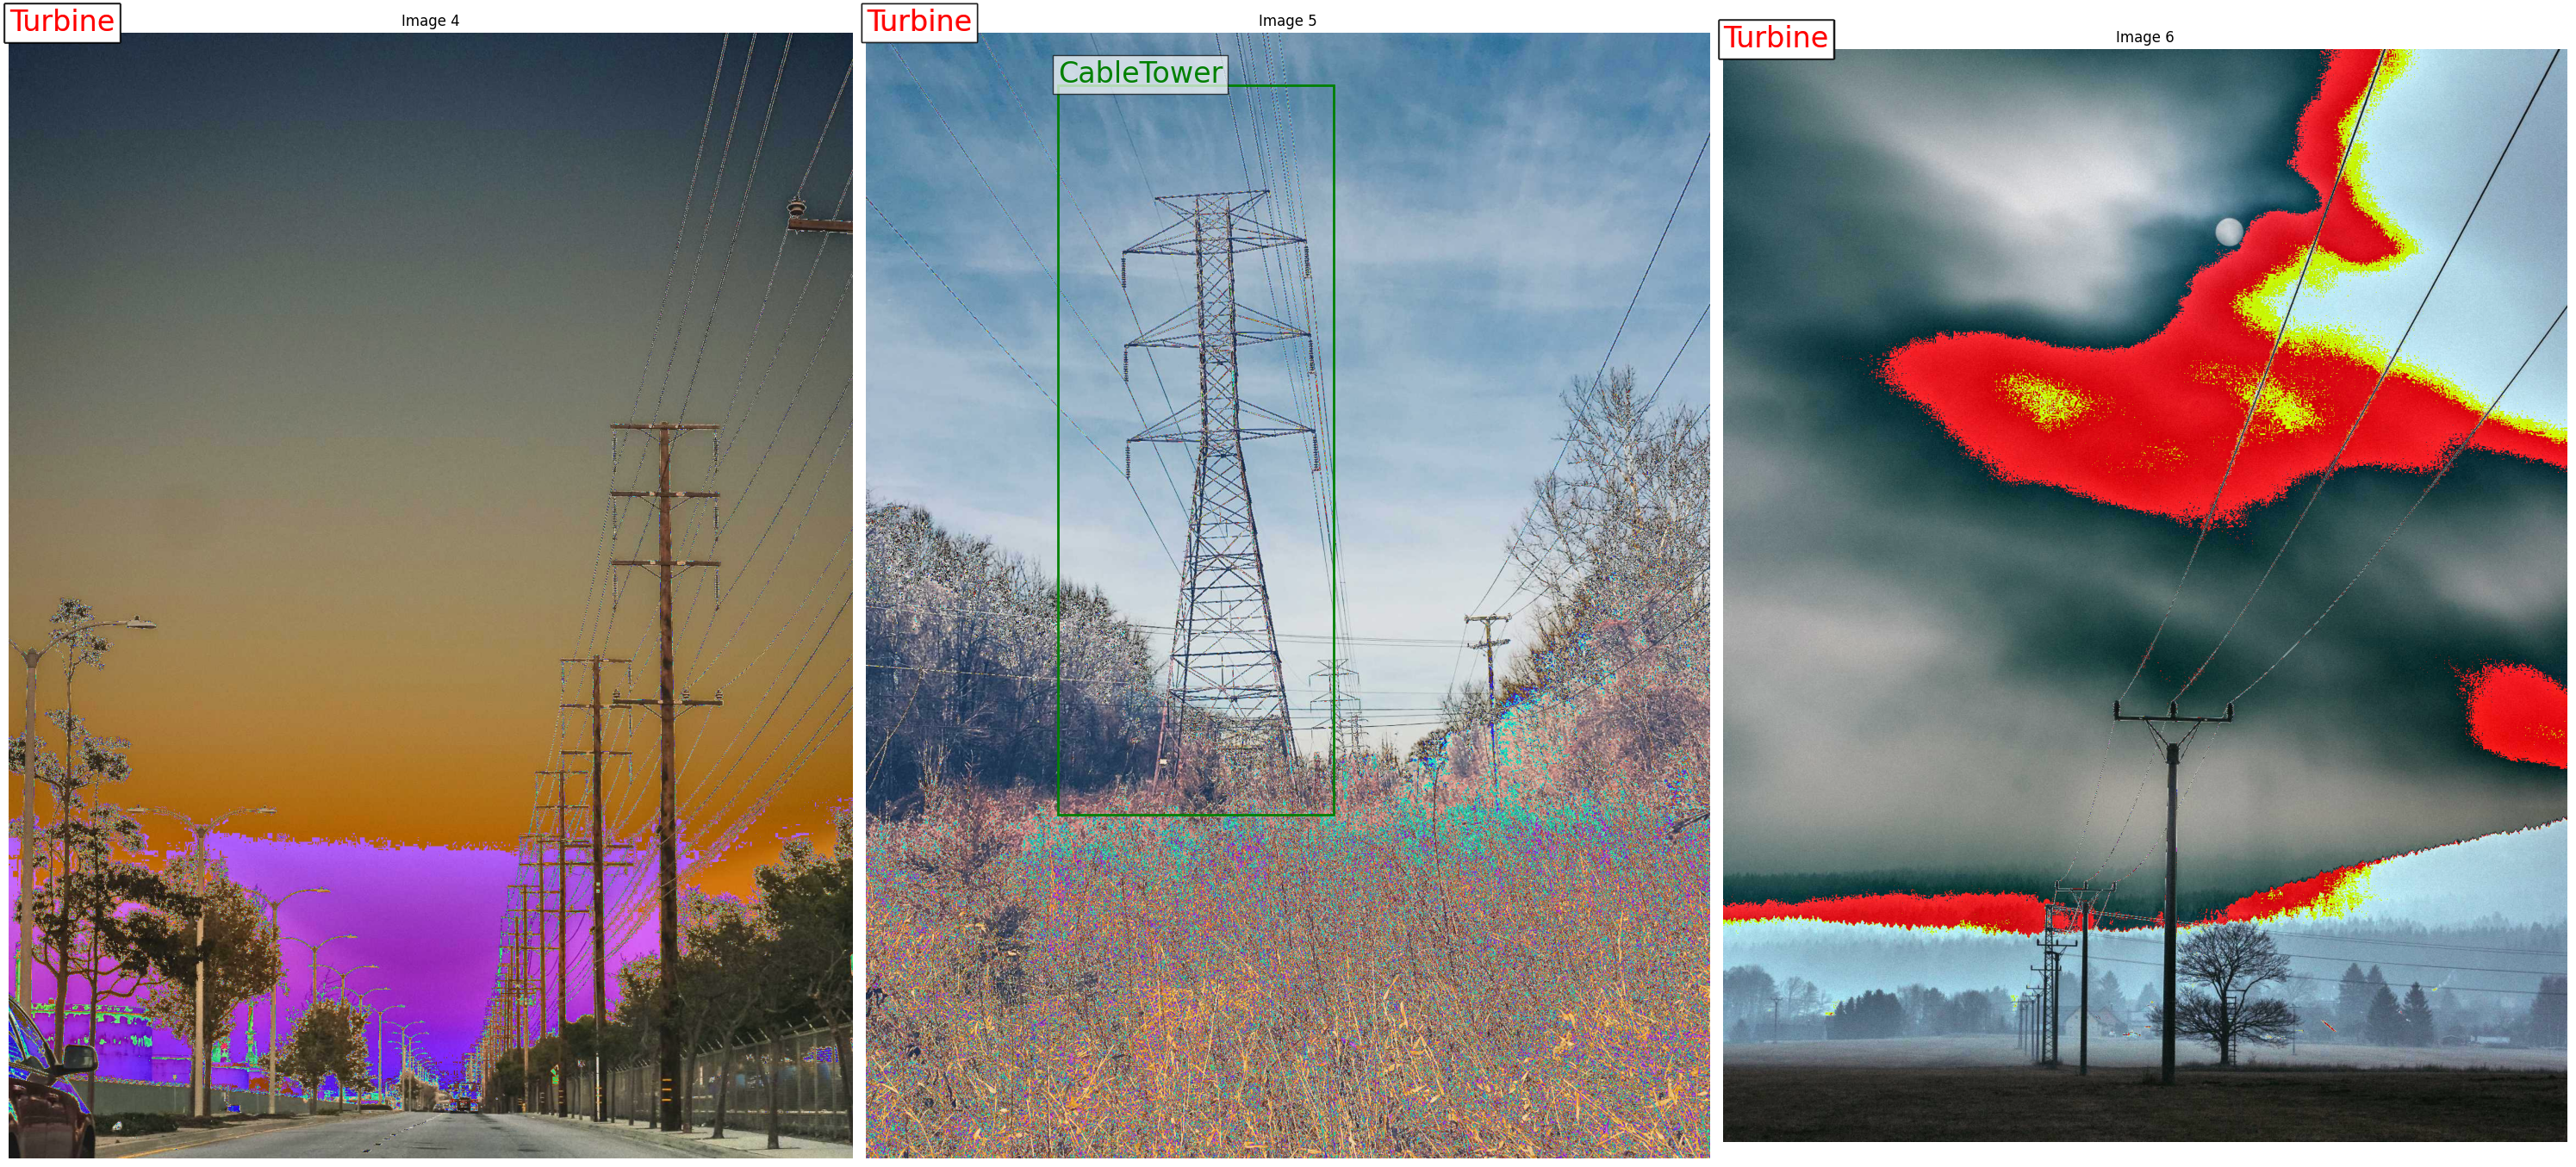

In [ ]:
# Select 3 random test images
test_indices = [4,5,6]

# Set model to evaluation mode
model.eval()

# Create figure with 5×2 subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 60))
axes = axes.ravel()  # Flatten axes for easy iteration

for i, idx in enumerate(test_indices):
    test_img, test_target = test_dataset[idx]
    
    # Extract Ground Truth Boxes & Labels
    gt_boxes = []
    gt_annotations = []
    for obj in test_target:
        boxes = test_target['boxes']
        labels = test_target['labels']
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            gt_boxes.append([x_min, y_min, width, height])
            gt_annotations.append(reverse_voc_classes[label.item()])

            
        

    # Run Model on Test Image
    with torch.no_grad():
        pred = model([test_img.to(device)])

    pred = pred[0]

    # Extract Predictions
    pred_boxes = pred['boxes'].cpu()  
    pred_annotations = pred['labels'].cpu()  
    pred_scores = pred['scores'].cpu()  

    # Apply Confidence Threshold (Only keep predictions with score ≥ 0.8)
    valid_mask = pred_scores >= 0.5
    pred_annotations = pred_annotations[valid_mask]
    pred_boxes = pred_boxes[valid_mask]

    # Convert Predicted Labels from Numeric to Class Names
    pred_annotations = [reverse_voc_classes[val.item()] for val in pred_annotations]

    # Overlay GT & Predictions on Image
    to_pil = transforms.ToPILImage()
    img = to_pil(test_img)
    ax = axes[i]
    ax.imshow(img)

    # Plot Ground Truth in RED
    for bbox, annotation in zip(gt_boxes, gt_annotations):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, annotation, color='r', fontsize=24, bbox=dict(facecolor='white', alpha=0.7))

    # Plot Predictions in GREEN
    for bbox, annotation in zip(pred_boxes, pred_annotations):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, annotation, color='g', fontsize=24, bbox=dict(facecolor='white', alpha=0.7))

    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.show()
